In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torchvision import datasets, transforms
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression

In [49]:
df = pd.read_csv("dataset.csv")
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [ ]:
# Smooth the entire temperature series first, then split
window_size = 7

# Smooth the entire temperature series
df['Temp_smooth'] = df['Temp'].rolling(window=window_size, center=True, min_periods=1).mean()



,Date,Temp,Temp_smooth
0,1981-01-01,20.7,18.000000
1,1981-01-02,17.9,17.560000
2,1981-01-03,18.8,17.266667
3,1981-01-04,14.6,17.057143
4,1981-01-05,15.8,16.585714
...,...,...,...
3645,1990-12-27,14.0,13.471429
3646,1990-12-28,13.6,13.900000
3647,1990-12-29,13.5,14.066667
3648,1990-12-30,15.7,13.960000


In [58]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Extract temperature series
temps = df['Temp'].values

In [59]:
def create_lag_features(arr, lag):
    X, y = [], []
    for i in range(lag, len(arr)):
        X.append(arr[i-lag:i])
        y.append(arr[i])
    return np.array(X), np.array(y)
lag = 3

temps_smooth = df['Temp_smooth'].values
X_smooth, y_smooth = create_lag_features(temps_smooth, lag)

In [63]:
train_size = int(len(X_smooth)*0.8)

X_train, X_test = X_smooth[:train_size], X_smooth[train_size:]
y_train, y_test = y_smooth[:train_size], y_smooth[train_size:]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.4211


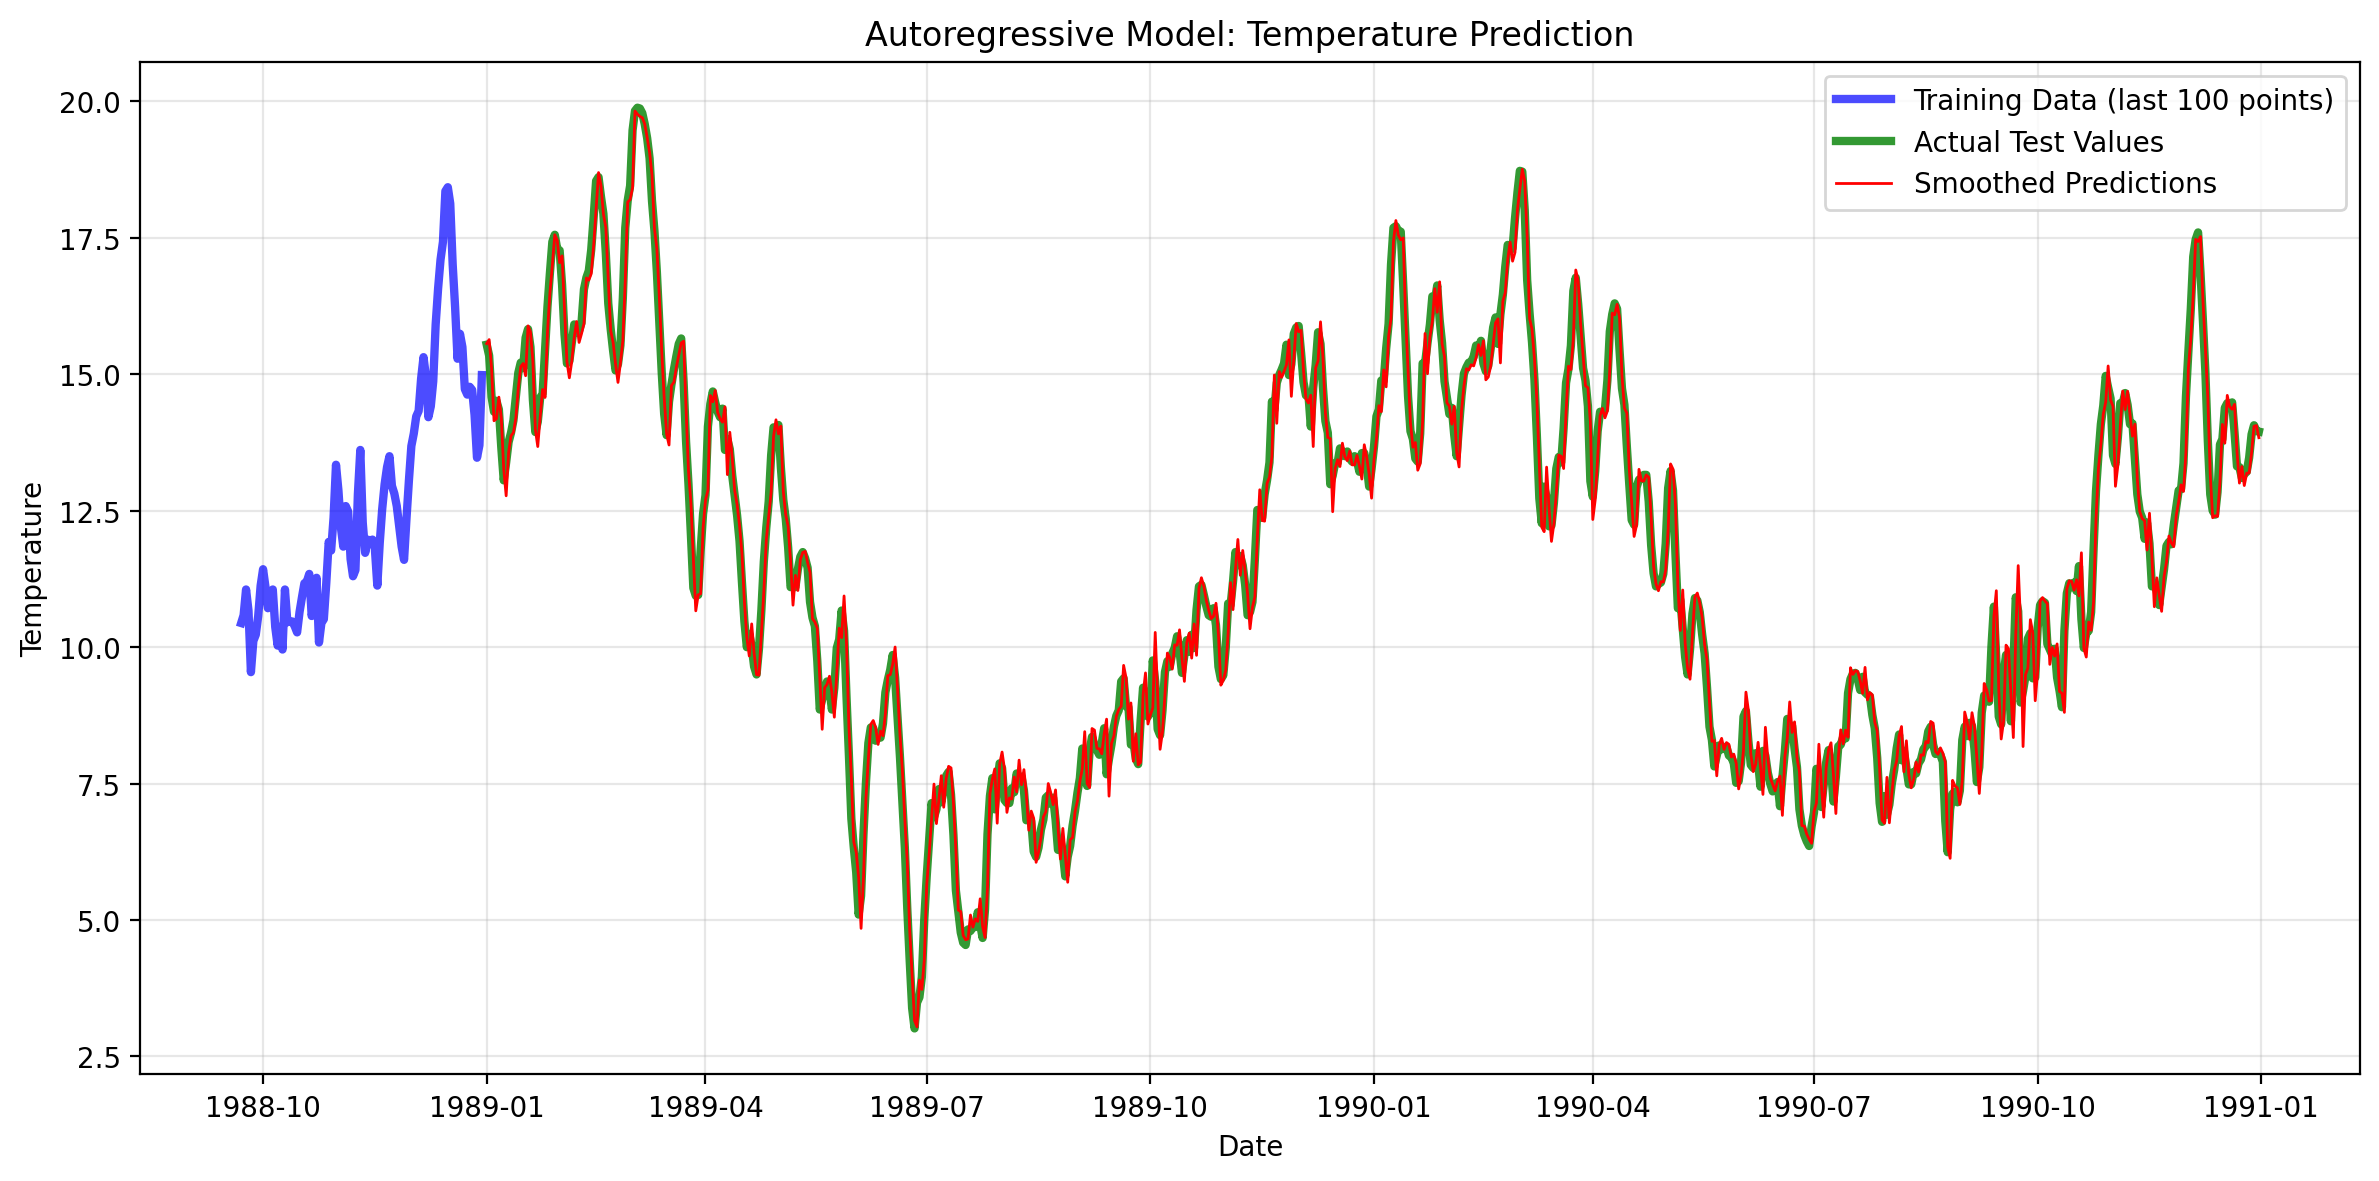

Smoothed RMSE: 0.4211


In [68]:
total_points = len(df)
train_size = len(X_train)


train_end_idx = train_size + lag
test_start_idx = train_end_idx
context_dates = df.index[train_end_idx - 100:train_end_idx]
context_temps_smooth = df['Temp_smooth'].iloc[train_end_idx - 100:train_end_idx]
test_dates = df.index[test_start_idx:test_start_idx + len(y_test)]

# Plot final result
plt.figure(figsize=(12, 6))

plt.plot(context_dates, context_temps_smooth, label='Training Data (last 100 points)', color='blue', linewidth=3, alpha=0.7)
plt.plot(test_dates, y_test, label='Actual Test Values', color='green', linewidth=3, alpha=0.8)
plt.plot(test_dates, y_pred, label='Smoothed Predictions', color='red', linewidth=1)

plt.title('Autoregressive Model: Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate RMSE for smoothed predictions
rmse_smooth = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Smoothed RMSE: {rmse_smooth:.4f}")